# Movie genre classification
Find movie genre by its Wikipedia plot description.

Dataset - [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Unpack `movie.metadata.tsv` and `plot_summaries.txt` files to the root folder of this project

## 1. Preprocessing
If you want to skip this step, you may download the [preprocessed dataset](https://drive.google.com/file/d/1U-CGGvlc3z3ayk2_qd-uOyUPiNkvsSjj/view?usp=sharing) and put the `preprocessed_dataset.csv` into the root folder.

1.1. Check for dataset

In [1]:
from os.path import exists

if not exists('movie.metadata.tsv'):
    raise Exception('movie.metadata.tsv was not found')

if not exists('plot_summaries.txt'):
    raise Exception('plot_summaries.txt was not found')

Exception: movie.metadata.tsv was not found

1.2. Load `movie.metadata.tsv`

In [2]:
import pandas as pd

meta = pd.read_csv("movie.metadata.tsv", sep = '\t', header = None)
meta.columns = ['Movie ID', 1, 2, 3, 4, 5, 6, 7, 'Genre']

# remove unnecessary columns
meta = meta.drop(columns=[1, 2, 3, 4, 5, 6, 7])

1.3. Genres are initially string type. Convert them to a dictionary

In [3]:
import json

genres = []

for i in meta["Genre"]:
    genres.append(list(json.loads(i).values()))

meta["Genre"] = genres

1.4. Overall, there are 363 genres in the dataset. We do not need so much. We reduced the number of genres to 19. After reducing, some movies are left without genres at all, so we remove such movies

In [4]:
def parse_genre(genre):
    if genre == "Black-and-white":
        return "Monochrome"
    if genre == "Family Film":
        return "Family"
    if genre == "War film":
        return "War"
    if genre == "Biographical film":
        return "Biography"
    if genre == "Crime Fiction":
        return "Crime"
    if genre == "Romance Film":
        return "Romance"
    return genre

all_general_genres = [
    'Animation',
    'Black-and-white',
    'Short Film',
    'Documentary',
    'Family Film',
    'Adventure',
    'Action',
    'Thriller',
    'Drama'
]

all_specific_genres = [
    'Horror',
    'Musical',
    'Fantasy',
    'War film',
    'Biography',
    'Biographical film',
    'Science Fiction',
    'Crime Fiction',
    'Romance Film',
    'Mystery',
    'Comedy'
]

meta_reduced_general_genres = []
meta_reduced_specific_genres = []

# reduce all movies genres by picking one general and one specific genre. Since the above genre arrays are sorted by priority, we select the first genre that is present both in the movie genre list and in the above array
for i in meta['Genre']:
    meta_general_genre = ""
    meta_specific_genre = ""
    for general_genre in all_general_genres:
        if general_genre in i:
            meta_general_genre = general_genre
            break

    for specific_genre in all_specific_genres:
        if specific_genre in i:
            meta_specific_genre = specific_genre
            break
    meta_reduced_general_genres.append(parse_genre(meta_general_genre))
    meta_reduced_specific_genres.append(parse_genre(meta_specific_genre))

# add two new columns: general and specific genres
meta["General genre"] = meta_reduced_general_genres
meta["Specific genre"] = meta_reduced_specific_genres

# remove movies without genres
meta = meta[~(meta['General genre'].str.len() == 0)]
meta = meta[~(meta['Specific genre'].str.len() == 0)]

# remove genre column
meta = meta.drop(columns="Genre")

1.5. Load `plot_summaries.txt`

In [5]:
import csv
from tqdm import tqdm

plot_summaries = []
movie_ids = []
plots = []

with open("plot_summaries.txt", 'r', encoding="utf8") as file:
       reader = csv.reader(file, dialect='excel-tab') 
       for row in tqdm(reader):
            plot_summaries.append(row)
            
for p in tqdm(plot_summaries):
    movie_ids.append(p[0])
    plots.append(p[1])

plot_data = {'Movie ID': movie_ids, 'Plot' : plots}
plot_df = pd.DataFrame(plot_data)

42303it [00:03, 13084.90it/s]
100%|██████████| 42303/42303 [00:00<00:00, 899449.18it/s]


1.6. Merge movies names and genres with their plot descriptions

In [6]:
merged = []
meta['Movie ID'] = meta['Movie ID'].astype(str)

# merge two tables according to id
merged = pd.merge(plot_df, meta[['Movie ID', 'General genre', 'Specific genre']], on = ['Movie ID'])

def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

merged = change_column_order(merged, 'Plot', 1)
merged = change_column_order(merged, 'General genre', 2)
merged = change_column_order(merged, 'Specific genre', 3)
merged = merged.drop(columns="Movie ID")


1.7. Clean plot descriptions by removing unnecessary symbols

In [7]:
import re

new_plot_summaries = []

def simplify_text(text):
    text = re.sub('\'','', text)
    text = re.sub('[^a-zA-Z]',' ', text)
    text = ' '.join(text.split())
    text = text.lower()
    return text

# clean the plot
merged['Plot Updated'] = merged['Plot'].apply(lambda l: simplify_text(l))
merged['Plot'] = merged['Plot Updated'].values

merged = merged.drop(columns='Plot Updated')

1.8. Clean plot descriptions by removing stopwords

In [8]:
import nltk
from nltk.corpus import stopwords

# download the list of stopwords from the nltk library
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    new_text = []
    for x in words:
        if x not in stop_words:
            new_text.append(x)
    return ' '.join(new_text)

# remove stop words from the plot
merged['Plot'] = merged['Plot'].apply(lambda l: remove_stopwords(l))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1.9. Save preprocessed data to the `preprocessed_dataset.csv` file

In [9]:
# save the dataframe as csv file
merged.to_csv('preprocessed_dataset.csv', index=False)

## 2. Feature extraction

2.1. Check for dataset

In [3]:
from os.path import exists

if not exists('preprocessed_dataset.csv'):
    raise Exception('preprocessed_dataset.csv was not found')

2.2. Load `preprocessed_dataset.csv`

In [4]:
import pandas as pd

movies = pd.read_csv("preprocessed_dataset.csv")

2.3. Split dataset to training and test sets

In [5]:
from sklearn.model_selection import train_test_split

# Split data to train and test sets
general_xtrain, general_xtest, general_ytrain, general_ytest = train_test_split(movies['Plot'], movies["General genre"], test_size=0.2, random_state=42)
specific_xtrain, specific_xtest, specific_ytrain, specific_ytest = train_test_split(movies['Plot'], movies["Specific genre"], test_size=0.2, random_state=42)

2.4. Extract features from plots (appr. 50-60 seconds)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Create vectorizer
general_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=15000, max_df=0.8)
specific_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=15000, max_df=0.8)

# create TF-IDF features
general_xtrain_tfidf = general_vectorizer.fit_transform(general_xtrain)
general_xtest_tfidf = general_vectorizer.transform(general_xtest)
specific_xtrain_tfidf = specific_vectorizer.fit_transform(specific_xtrain)
specific_xtest_tfidf = specific_vectorizer.transform(specific_xtest)

## 3. Model building

3.1. HyperParameter optimization (Note: if you run this block, the next step will run for more than an hour due to the optimization. But you can skip this step, then the next step will just use hardcoded models)

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
 
# defining parameter range
param_grid = {'C': [0.00001, 0.0001, 0.001, 0.08, 0.09, 0.1, 0.2, 0.3, 1, 10, 100],
              'tol': [0.00001, 0.0001, 0.001, 0.08, 0.09, 0.1],
              'class_weight': ['balanced', None]}
 
general_svc_optimized = GridSearchCV(LinearSVC(random_state=42), param_grid, refit = True, verbose = 3)
specific_svc_optimized = GridSearchCV(LinearSVC(random_state=42), param_grid, refit = True, verbose = 3)

3.2. Model training and testing

In [7]:
from sklearn.svm import LinearSVC

if 'general_svc_optimized' in locals():
    # use hyperoptimized models
    general_svc_optimized.fit(general_xtrain_tfidf, general_ytrain)
    specific_svc_optimized.fit(specific_xtrain_tfidf, specific_ytrain)

    general_y_pred = general_svc_optimized.predict(general_xtest_tfidf)
    specific_y_pred = specific_svc_optimized.predict(specific_xtest_tfidf)
else:
    # use hardcoded models (parameters were obtained by hyperoptimization)
    general_svc = LinearSVC(C=0.8, class_weight='balanced', tol=0.5, random_state=42)
    specific_svc = LinearSVC(C=0.2, tol=0.5, random_state=42)

    general_svc.fit(general_xtrain_tfidf, general_ytrain)
    specific_svc.fit(specific_xtrain_tfidf, specific_ytrain)

    general_y_pred = general_svc.predict(general_xtest_tfidf)
    specific_y_pred = specific_svc.predict(specific_xtest_tfidf)

# 4. Model evaluation

4.1. Metrics

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Value metrics
print(classification_report(general_ytest, general_y_pred))
print(classification_report(specific_ytest, specific_y_pred))

              precision    recall  f1-score   support

      Action       0.48      0.48      0.48       544
   Adventure       0.31      0.39      0.35       279
   Animation       0.54      0.63      0.58       256
 Documentary       0.55      0.60      0.58        60
       Drama       0.66      0.66      0.66      1292
      Family       0.38      0.38      0.38       248
  Monochrome       0.49      0.48      0.48       458
  Short Film       0.20      0.11      0.14        76
    Thriller       0.53      0.48      0.50       609

    accuracy                           0.53      3822
   macro avg       0.46      0.47      0.46      3822
weighted avg       0.53      0.53      0.53      3822

                 precision    recall  f1-score   support

      Biography       0.52      0.21      0.30       149
         Comedy       0.55      0.55      0.55       672
          Crime       0.59      0.73      0.65       690
        Fantasy       0.58      0.44      0.50       268
         

4.2. Confusion matrices

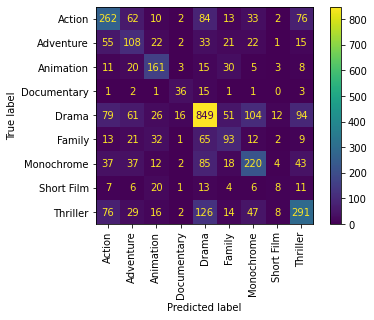

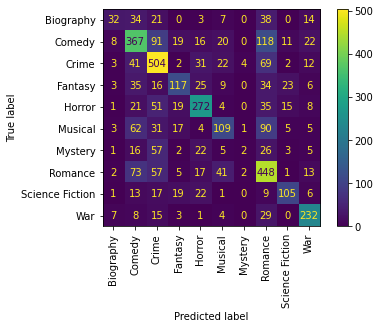

In [9]:
import matplotlib.pyplot as plt

# Confusion matrices
general_cm = confusion_matrix(general_ytest, general_y_pred, labels=general_svc.classes_)
specific_cm = confusion_matrix(specific_ytest, specific_y_pred, labels=specific_svc.classes_)

general_cm_plot = ConfusionMatrixDisplay(confusion_matrix=general_cm, display_labels=general_svc.classes_)
specific_cm_plot = ConfusionMatrixDisplay(confusion_matrix=specific_cm, display_labels=specific_svc.classes_)

general_cm_plot.plot()
plt.xticks(rotation = 90)
specific_cm_plot.plot()
plt.xticks(rotation = 90)

plt.show()

4.3. Accuracy 

In [28]:
from sklearn.metrics import accuracy_score

print("Accuracy: ", accuracy_score(general_ytest, general_y_pred))
print("Specific Accuracy: ", accuracy_score(specific_ytest, specific_y_pred))

Accuracy:  0.5306122448979592
Specific Accuracy:  0.5724751439037153


4.4. Logistic Regression

             Thriller  Drama  Family  Short Film  Monochrome  Adventure  \
Thriller          262     62      10           2          84         13   
Drama              55    108      22           2          33         21   
Family             11     20     161           3          15         30   
Short Film          1      2       1          36          15          1   
Monochrome         79     61      26          16         849         51   
Adventure          13     21      32           1          65         93   
Animation          37     37      12           2          85         18   
Documentary         7      6      20           1          13          4   
Action             76     29      16           2         126         14   

             Animation  Documentary  Action  
Thriller            33            2      76  
Drama               22            1      15  
Family               5            3       8  
Short Film           1            0       3  
Monochrome         

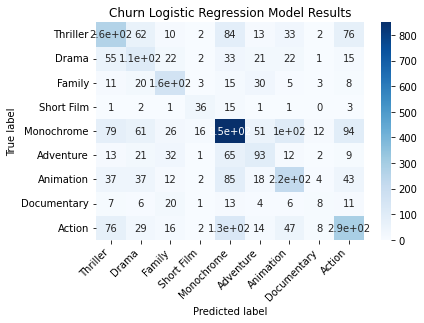

In [38]:
from sklearn.metrics import confusion_matrix
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

conmat = confusion_matrix(general_ytest, general_y_pred)
val = np.mat(conmat) 

classnames = list(set(general_ytest))

df_cm = pd.DataFrame(

        val, index=classnames, columns=classnames, 

    )


print(df_cm)

plt.figure()

heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.title('Regression Results')

plt.show()  

## 5. Empirical tests

5.1. Define helper functions (if you skipped part 1 - preprocessing)

In [10]:
import re
import nltk
from nltk.corpus import stopwords

def simplify_text(text):
    text = re.sub('\'','', text)
    text = re.sub('[^a-zA-Z]',' ', text)
    text = ' '.join(text.split())
    text = text.lower()
    return text

# download the list of stopwords from the nltk library
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    new_text = []
    for x in words:
        if x not in stop_words:
            new_text.append(x)
    return ' '.join(new_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


5.2. Define test functions

In [11]:
def clean_plot(plot):
    plot = simplify_text(plot)
    plot = remove_stopwords(plot)
    return plot

def find_general_genre(plot):
    q_vec = general_vectorizer.transform([plot])
    general_genre_pred = general_svc.predict(q_vec)
    return general_genre_pred

def find_specific_genre(plot):
    q_vec = specific_vectorizer.transform([plot])
    specific_genre_pred = specific_svc.predict(q_vec)
    return specific_genre_pred

def find_genres(plot):
    plot = clean_plot(plot)
    general_genre = find_general_genre(plot)
    specific_genre = find_specific_genre(plot)
    return general_genre + ", " + specific_genre

5.3. Test

In [18]:
# Movie: Fantastic Beasts: The Secrets of Dumbledore (2022)- Fantasy, Superhero, Drama, Animation
# Movie: The Batman (2022) -Action, Crime, Superhero, Mystery, Drama, Adventure
# Movie: Navalny - Crime, Documentary, Thriller, Mystery
# Movie: Jersey - Drama, Sports, Romane, Comedy
# Movie: Malignant - horror, Crime, Thriller, Mystery
# Movie: The Deep House - Short film, Thriller, Horror
# Movie: Five Feet Apart - Romance, Comedy, Drama
plot_1 = "Professor Albus Dumbledore knows the powerful, dark wizard Gellert Grindelwald is moving to seize control of the wizarding world. Unable to stop him alone, he entrusts magizoologist Newt Scamander to lead an intrepid team of wizards and witches. They soon encounter an array of old and new beasts as they clash with Grindelwald's growing legion of followers."
plot_2 = "On Halloween, Gotham City mayor Don Mitchell Jr. is murdered by a man calling himself the Riddler. Reclusive billionaire Bruce Wayne, who has operated for two years as the vigilante Batman, investigates alongside the Gotham City Police Department (GCPD). Lieutenant James Gordon discovers a message that the Riddler left for Batman. The Riddler kills commissioner Pete Savage and leaves another message for Batman. Batman and Gordon discover that the Riddler left a thumb drive in Mitchell's car containing images of Mitchell with a woman, Annika Koslov, at the Iceberg Lounge—a nightclub operated by the Penguin, mobster Carmine Falcone's lieutenant. While the Penguin pleads ignorance, Batman notices that Selina Kyle, Annika's roommate and friend, works at the club as a waitress. When Annika disappears, Batman sends Selina back to the Iceberg Lounge for answers and discovers that Savage was on Falcone's payroll, as is district attorney Gil Colson. The Riddler abducts Colson, straps a timed collar bomb to his neck, and sends him to interrupt Mitchell's funeral. When Batman arrives, the Riddler calls him via Colson's phone and threatens to detonate the bomb if Colson cannot answer three riddles. Colson refuses to answer the third—the name of the informant who gave the GCPD information that led to a historic drug bust ending mobster Salvatore Maroni's operation—and dies. Batman and Gordon deduce that the informant may be the Penguin and track him to a drug deal. They discover that Maroni's operation transferred to Falcone, with many corrupt GCPD officers involved. Selina inadvertently exposes them when she arrives to steal money and discovers Annika's corpse in a car trunk. After a car chase, Batman captures the Penguin but learns he is not the informant. Batman and Gordon follow the Riddler's trail to the ruins of an orphanage funded by Bruce's murdered parents, Thomas and Martha Wayne, where they learn that the Riddler holds a grudge against the Wayne family. Bruce's butler and caretaker, Alfred Pennyworth, is hospitalized after opening a letter bomb addressed to Bruce. The Riddler leaks evidence that Thomas, who was running for mayor before he was murdered, hired Falcone to kill a journalist for threatening to reveal details about Martha and her family's history of mental illness. Bruce, who grew up believing his father was morally upstanding, confronts Alfred, who maintains that Thomas only asked Falcone to threaten the journalist into silence; Thomas planned to turn himself and Falcone over to the police once he found out Falcone murdered the journalist instead. Alfred believes that Falcone had Thomas and Martha killed to prevent this. Selina reveals to Batman that Falcone is her neglectful father. She decides to kill him after learning that he strangled Annika because Mitchell told her that Falcone was the informant. Batman and Gordon arrive in time to stop her, but the Riddler kills Falcone as he is being arrested. The Riddler is unmasked as forensic accountant Edward Nashton and is incarcerated in Arkham State Hospital, where he tells Batman he took inspiration from him when targeting the corrupt. Batman learns that Nashton has stationed car bombs around Gotham and cultivated an online following that plans to assassinate mayor-elect Bella Reál. The bombs destroy the seawall around Gotham and flood the city. Nashton's followers attempt to kill Reál but are stopped by Batman and Selina. In the aftermath, Nashton befriends another inmate, while Selina deems Gotham beyond saving and leaves. Batman aids recovery efforts and vows to inspire hope in Gotham."
plot_3 = "Detailing the 2020 assassination attempt of Russian opposition leader and former presidential candidate Alexei Navalny, in which he was poisoned with a military-grade nerve agent."
plot_4 = "A talented but failed cricketer decides to return to cricket in his late thirties driven by the desire to represent the Indian cricket team and fulfil his son's wish for a jersey as a gift."
plot_5 = "Madison, a young woman, is terrified by visions of the murders of strangers. Later, Madison decides to find and save the victims."
plot_6 = "While diving in a remote French lake, two YouTubers who specialize in underwater exploration videos discover a house submerged in deep waters. Their dive turns into a nightmare when they discover the house was the scene of atrocious crimes."
plot_7 = "Seventeen-year-old Stella spends most of her time in the hospital as a cystic fibrosis patient. Her life is full of routines, boundaries and self-control -- all of which get put to the test when she meets Will, an impossibly charming teen who has the same illness. There's an instant flirtation, though restrictions dictate that they must maintain a safe distance between them."
print(find_genres(plot_1))
print(find_genres(plot_2))
print(find_genres(plot_3))
print(find_genres(plot_4))
print(find_genres(plot_5))
print(find_genres(plot_6))
print(find_genres(plot_7))

['Animation, Fantasy']
['Action, Crime']
['Thriller, Crime']
['Drama, Comedy']
['Thriller, Horror']
['Short Film, Horror']
['Drama, Romance']
